In [7]:
#!/usr/bin/env python

# Simple example of Wiener deconvolution in Python.
# We use a fixed SNR across all frequencies in this example.
#
# Written 2015 by Dan Stowell. Public domain.

import numpy as np
from numpy.fft import fft, ifft, ifftshift

import matplotlib
#matplotlib.use('PDF') # http://www.astrobetter.com/plotting-to-a-file-in-python/
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams.update({'font.size': 6})



In [34]:

##########################
# user config
sonlen  = 500
irlen   =  26

lambd_est = 1e-3  # estimated noise lev

##########################


In [35]:
from scipy.stats import gamma
from math import floor, ceil

In [36]:
def spm_Gpdf(x, α, β):
    return gamma(a=α, scale=1/β).pdf(x)

def spm_hrf(RT):
    p = np.array([6., 16., 1., 1., 6., 0., 32.])
    fMRI_T = 16
    
    dt = RT / fMRI_T
    u = np.arange(0, ceil(p[6]/dt)) - (p[5]/dt)
    
    hrf = spm_Gpdf(u, p[0]/p[2], dt/p[2]) - spm_Gpdf(u, p[1]/p[3], dt/p[3])/p[4]
    hrf = hrf[np.arange(0, floor(p[6]/RT))*fMRI_T + 1]
    return hrf/np.sum(hrf)

In [46]:
def gen_son(length):
    "Generate a synthetic un-reverberated 'sound event' template"
    # (whitenoise -> integrate -> envelope -> normalise)
    son = np.cumsum(np.random.randn(length))
    # apply envelope
    attacklen = int(length / 8)
    env = np.hstack((np.linspace(0.1, 1, attacklen), np.linspace(1, 0.1, length - attacklen)))
    son *= env
    #son /= np.sqrt(np.sum(son * son))
    return son

def gen_ir(length):
    "Generate a synthetic impulse response"
    # First we generate a quietish tail
    son = np.random.randn(length)
    attacklen = int(length / 2)
    env = np.hstack((np.linspace(0.1, 1, attacklen), np.linspace(1, 0.1, length - attacklen)))
    son *= env
    son *= 0.05
    # Here we add the "direct" signal
    son[0] = 1
    # Now some early reflection spikes
    for _ in range(10):
        son[ int(length * (np.random.rand()**2))  ] += np.random.randn() * 0.5
    # Normalise and return
    son /= np.sqrt(np.sum(son * son))
    return spm_hrf(1.2)

def wiener_deconvolution(signal, kernel, lambd):
    "lambd is the SNR"
    print(len(signal), len(kernel))
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd**2)))
    return deconvolved

525 26
525 500
single_example_test(): RMS errors son 0.0957102, IR 0.000244762


Text(0.5, 1.0, 'obs')

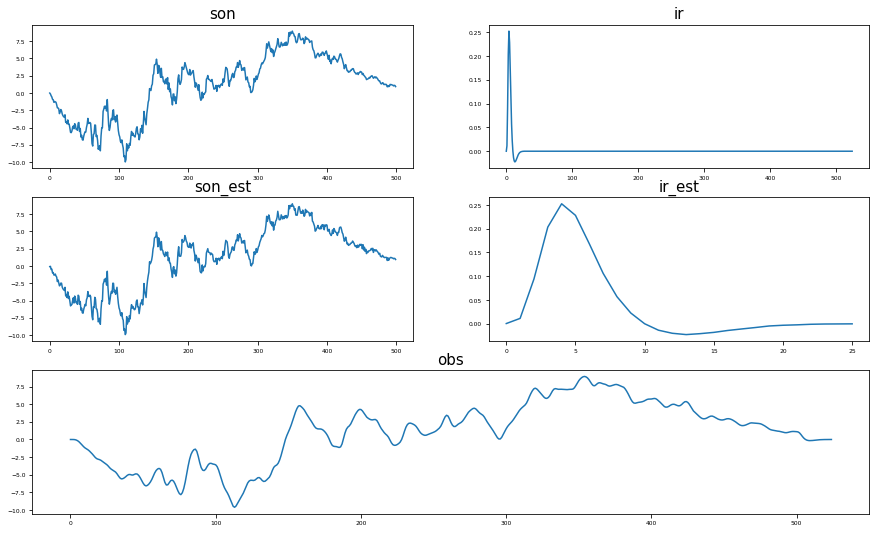

In [58]:
"simple test: get one soundtype and one impulse response, convolve them, deconvolve them, and check the result (plot it!)"
son = gen_son(sonlen)
ir  = gen_ir(irlen)
obs = np.convolve(son, ir, mode='full')
# let's add some noise to the obs
obs += np.random.randn(*obs.shape) * lambd_est
son_est = wiener_deconvolution(obs, ir,  lambd=lambd_est)[:sonlen]
ir_est  = wiener_deconvolution(obs, son, lambd=lambd_est)[:irlen]
# calc error
son_err = np.sqrt(np.mean((son - son_est) ** 2))
ir_err  = np.sqrt(np.mean((ir  -  ir_est) ** 2))
print("single_example_test(): RMS errors son %g, IR %g" % (son_err, ir_err))
# plot
pdf = PdfPages('wiener_deconvolution_example.pdf')
plt.figure(frameon=False, figsize=(15, 9))
#
plt.subplot(3,2,1)
plt.plot(son)
plt.title("son", fontsize=15)
plt.subplot(3,2,3)
plt.plot(son_est)
plt.title("son_est", fontsize=15)
plt.subplot(3,2,2)
plt.plot(np.hstack((ir, np.zeros(len(obs) - len(ir)))))
plt.title("ir", fontsize=15)
plt.subplot(3,2,4)
plt.plot(ir_est)
plt.title("ir_est", fontsize=15)
plt.subplot(3,1,3)
plt.plot(obs)
plt.title("obs", fontsize=15)
#

300 26
single_example_test(): RMS errors son 0.113596, IR 0.00026593


Text(0.5, 1.0, 'obs')

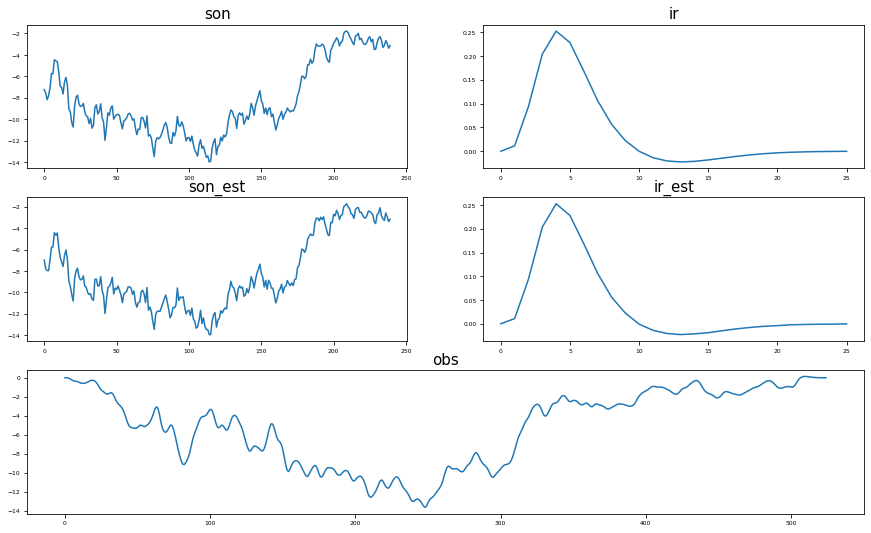

In [56]:
"simple test: get one soundtype and one impulse response, convolve them, deconvolve them, and check the result (plot it!)"
son = gen_son(sonlen)
ir  = gen_ir(irlen)
obs = np.convolve(son, ir, mode='full')
# let's add some noise to the obs
obs += np.random.randn(*obs.shape) * lambd_est
son_est = wiener_deconvolution(obs[100:400], ir,  lambd=lambd_est)[:sonlen][30:-30]
#ir_est  = wiener_deconvolution(obs, son, lambd=lambd_est)[:irlen]
# calc error
son_err = np.sqrt(np.mean((son[130:370] - son_est) ** 2))
ir_err  = np.sqrt(np.mean((ir  -  ir_est) ** 2))
print("single_example_test(): RMS errors son %g, IR %g" % (son_err, ir_err))
# plot
pdf = PdfPages('wiener_deconvolution_example.pdf')
plt.figure(frameon=False, figsize=(15, 9))
#
plt.subplot(3,2,1)
plt.plot(son[130:370])
plt.title("son", fontsize=15)
plt.subplot(3,2,3)
plt.plot(son_est)
plt.title("son_est", fontsize=15)
plt.subplot(3,2,2)
plt.plot(ir)
plt.title("ir", fontsize=15)
plt.subplot(3,2,4)
plt.plot(ir_est)
plt.title("ir_est", fontsize=15)
plt.subplot(3,1,3)
plt.plot(obs)
plt.title("obs", fontsize=15)
#

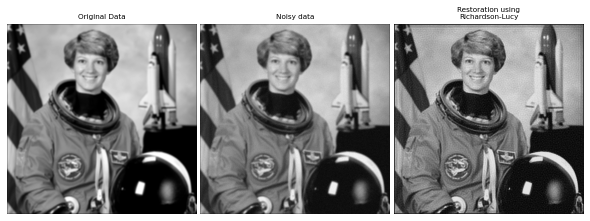

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration

rng = np.random.default_rng()

astro = color.rgb2gray(data.astronaut())

psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (rng.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

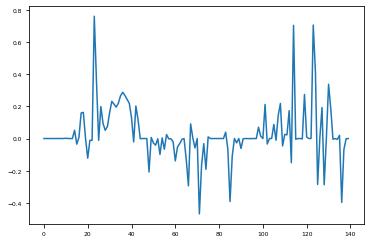

In [20]:
estimate = restoration.richardson_lucy(np.array([obs]), np.array([spm_hrf(1.2)]))

plt.plot(estimate.T)

In [16]:
psf

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])